In [3]:
# trainデータを作る

from PIL import Image, ImageDraw, ImageFont
import os
import random

project_dir = "./"
output_dir = project_dir+"font_data/"
os.makedirs(output_dir, exist_ok=True)

WHITE = (255,255,255)
BLACK = (0,0,0)
RED = (255,0,0)
GREEN = (0,255,0)
BLUE = (0,0,255)

fonts = [
    ["input","notoserifjp/NotoSerifJP-ExtraLight.ttf"],
    ["target","newtegomin/NewTegomin-Regular.ttf"],
]
sizes = [ 30, 70, 100 ]
texts = [
    "朕󠄁は、日本國民の總意に基いて、新日本建設の礎が、定まるに至つたことを、深くよろこび、樞密顧問の諮󠄁詢及び帝󠄁國憲󠄁法第七十三條による帝󠄁國議會の議決を經た帝󠄁國憲󠄁法の改正を裁可し、ここにこれを公󠄁布せしめる。",
    "日本國民は、正當に選󠄁擧された國會における代表者を通󠄁じて行動し、われらとわれらの子孫のために、諸國民との協和による成󠄁果と、わが國全󠄁土にわたつて自由のもたらす惠澤を確保し、政府の行爲によつて再び戰爭の慘禍が起ることのないやうにすることを決意し、ここに主權が國民に存することを宣言し、この憲󠄁法を確定する。そもそも國政は、國民の嚴肅な信託によるものであつて、その權威は國民に由來し、その權力は國民の代表者がこれを行使󠄁し、その福利は國民がこれを享受する。これは人類普遍󠄁の原理であり、この憲󠄁法は、かかる原理に基くものである。われらは、これに反する一切の憲󠄁法、法令及び詔勅を排除する。日本國民は、恒久の平󠄁和を念願し、人間相互の關係を支配する崇高な理想を深く自覺するのであつて、平󠄁和を愛する諸國民の公󠄁正と信義に信賴して、われらの安全󠄁と生存を保持しようと決意した。われらは、平󠄁和を維持し、專制と隷從、壓迫󠄁と偏狹を地上から永遠󠄁に除去しようと努めてゐる國際社會において、名譽ある地位を占めたいと思ふ。われらは、全󠄁世界の國民が、ひとしく恐󠄁怖と缺乏から免かれ、平󠄁和のうちに生存する權利を有することを確認󠄁する。われらは、いづれの國家も、自國のことのみに專念して他國を無視してはならないのであつて、政治道󠄁德の法則は、普遍󠄁的なものであり、この法則に從ふことは、自國の主權を維持し、他國と對等關係に立たうとする各國の責務であると信ずる。日本國民は、國家の名譽にかけ、全󠄁力をあげてこの崇高な理想と目的を達󠄁成󠄁することを誓ふ。",
    "私は、犬については自信がある。いつの日か、かならず喰くいつかれるであろうという自信である。私は、きっと噛かまれるにちがいない。自信があるのである。よくぞ、きょうまで喰いつかれもせず無事に過してきたものだと不思議な気さえしているのである。諸君、犬は猛獣である。馬を斃たおし、たまさかには獅子ししと戦ってさえこれを征服するとかいうではないか。さもありなんと私はひとり淋しく首肯しゅこうしているのだ。あの犬の、鋭い牙きばを見るがよい。ただものではない。いまは、あのように街路で無心のふうを装い、とるに足らぬもののごとくみずから卑下して、芥箱ごみばこを覗のぞきまわったりなどしてみせているが、もともと馬を斃すほどの猛獣である。いつなんどき、怒り狂い、その本性を暴露するか、わかったものではない。犬はかならず鎖に固くしばりつけておくべきである。少しの油断もあってはならぬ。世の多くの飼い主は、みずから恐ろしき猛獣を養い、これに日々わずかの残飯ざんぱんを与えているという理由だけにて、まったくこの猛獣に心をゆるし、エスやエスやなど、気楽に呼んで、さながら家族の一員のごとく身辺に近づかしめ、三歳のわが愛子をして、その猛獣の耳をぐいと引っぱらせて大笑いしている図にいたっては、戦慄せんりつ、眼を蓋おおわざるを得ないのである。不意に、わんといって喰いついたら、どうする気だろう。気をつけなければならぬ。飼い主でさえ、噛みつかれぬとは保証できがたい猛獣を、（飼い主だから、絶対に喰いつかれぬということは愚かな気のいい迷信にすぎない。あの恐ろしい牙のある以上、かならず噛む。けっして噛まないということは、科学的に証明できるはずはないのである）その猛獣を、放し飼いにして、往来をうろうろ徘徊はいかいさせておくとは、どんなものであろうか。昨年の晩秋、私の友人が、ついにこれの被害を受けた。いたましい犠牲者である。友人の話によると、友人は何もせず横丁を懐手ふところでしてぶらぶら歩いていると、犬が道路上にちゃんと坐っていた。友人は、やはり何もせず、その犬の傍を通った。犬はその時、いやな横目を使ったという。何事もなく通りすぎた、とたん、わんといって右の脚あしに喰いついたという。災難である。一瞬のことである。友人は、呆然自失ぼうぜんじしつしたという。ややあって、くやし涙が沸いて出た。さもありなん、と私は、やはり淋しく首肯している。",
    "いろはにほへとちりぬるをわかよたれそつねならむうゐのおくやまけふこえてあさきゆめみしゑひもせす",
    "色は匂へど散りぬるを我が世誰ぞ常ならむ有為の奥山今日越えて浅き夢見し酔ひもせず",
    "the quick brown fox jumps over the lazy dog. 0123456789",
    "From fairest creatures we desire increase, That thereby beauty's rose might never die, But as the riper should by time decease, His tender heir might bear his memory:",
    "When we look to the individuals of the same variety or sub-variety of our older cultivated plants and animals, one of the first points which strikes us, is, that they generally differ much more from each other, than do the individuals of any one species or variety in a state of nature. When we reflect on the vast diversity of the plants and animals which have been cultivated, and which have varied during all ages under the most different climates and treatment, I think we are driven to conclude that this greater variability is simply due to our domestic productions having been raised under conditions of life not so uniform as, and somewhat different from, those to which the parent-species have been exposed under nature. There is, also, I think, some probability in the view propounded by Andrew Knight, that this variability may be partly connected with excess of food. It seems pretty clear that organic beings must be exposed during several generations to the new conditions of life to cause any appreciable amount of variation; and that when the organisation has once begun to vary, it generally continues to vary for many generations. No case is on record of a variable being ceasing to be variable under cultivation. Our oldest cultivated plants, such as wheat, still often yield new varieties: our oldest domesticated animals are still capable of rapid improvement or modification.",
]

for path in ["train"]:
    for size in sizes:
        textcnt = 0
        for text in texts:
            print(textcnt)
            textcnt += 1
            for font in fonts:
                font_path = project_dir+"/font_data/font/"+font[1]
                fontPIL = ImageFont.truetype(font_path, size)
                os.makedirs(os.path.join(output_dir,path,font[0]), exist_ok=True)
                x = 10
                y = 20
                img = Image.new("RGB", (256, 256), WHITE)
                draw = ImageDraw.Draw(img)
                x1, y1, x2, y2 = draw.textbbox((x,y), text, fontPIL)
                slide = -150
                i = 0
                while x>-x2+10:
                    img = Image.new("RGB", (256, 256), WHITE)
                    draw = ImageDraw.Draw(img)
                    draw.text(xy=(x,y), text=text, fill=BLACK, font=fontPIL)
                    x += slide
                    img.save(os.path.join(output_dir, path, font[0], f"{textcnt}-{size}-{i}.png"))
                    i+=1

0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7
0
1
2
3
4
5
6
7


Epoch [0/10000], Step [0/14], Loss_G: 106.18048858642578, Loss_D: 0.7221645712852478
Epoch [1/10000], Step [0/14], Loss_G: 59.76720428466797, Loss_D: 0.047593601047992706
Epoch [2/10000], Step [0/14], Loss_G: 45.96683883666992, Loss_D: 0.019032102078199387
Epoch [3/10000], Step [0/14], Loss_G: 36.355201721191406, Loss_D: 0.008545712567865849
Epoch [4/10000], Step [0/14], Loss_G: 30.068572998046875, Loss_D: 0.005965795833617449
Epoch [5/10000], Step [0/14], Loss_G: 27.544404983520508, Loss_D: 0.0031262135598808527
Epoch [6/10000], Step [0/14], Loss_G: 22.90877914428711, Loss_D: 0.0025428375229239464
Epoch [7/10000], Step [0/14], Loss_G: 15.684803009033203, Loss_D: 0.09780611097812653
Epoch [8/10000], Step [0/14], Loss_G: 16.262828826904297, Loss_D: 0.010539434850215912
Epoch [9/10000], Step [0/14], Loss_G: 15.614215850830078, Loss_D: 0.006309923715889454


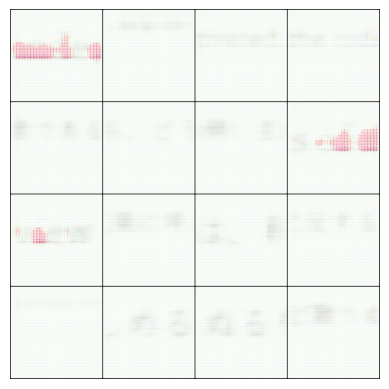

Epoch [10/10000], Step [0/14], Loss_G: 15.13430404663086, Loss_D: 0.004532899707555771
Epoch [11/10000], Step [0/14], Loss_G: 13.322993278503418, Loss_D: 0.013767523691058159
Epoch [12/10000], Step [0/14], Loss_G: 7.773131847381592, Loss_D: 0.586353063583374
Epoch [13/10000], Step [0/14], Loss_G: 7.156963348388672, Loss_D: 0.501602292060852
Epoch [14/10000], Step [0/14], Loss_G: 7.922059535980225, Loss_D: 0.6629286408424377
Epoch [15/10000], Step [0/14], Loss_G: 7.699980735778809, Loss_D: 0.29194164276123047
Epoch [16/10000], Step [0/14], Loss_G: 7.926933765411377, Loss_D: 0.5566567182540894
Epoch [17/10000], Step [0/14], Loss_G: 9.029672622680664, Loss_D: 0.45766180753707886
Epoch [18/10000], Step [0/14], Loss_G: 8.362360000610352, Loss_D: 0.4067053496837616
Epoch [19/10000], Step [0/14], Loss_G: 8.557015419006348, Loss_D: 0.5170217752456665


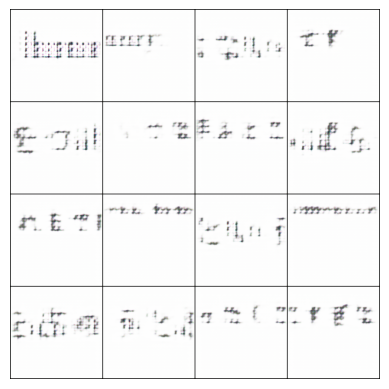

Epoch [20/10000], Step [0/14], Loss_G: 8.231805801391602, Loss_D: 0.373487651348114
Epoch [21/10000], Step [0/14], Loss_G: 7.620613098144531, Loss_D: 0.4215233027935028
Epoch [22/10000], Step [0/14], Loss_G: 7.60035514831543, Loss_D: 0.46129748225212097
Epoch [23/10000], Step [0/14], Loss_G: 6.834926605224609, Loss_D: 0.6912854313850403
Epoch [24/10000], Step [0/14], Loss_G: 7.119016170501709, Loss_D: 0.975657045841217
Epoch [25/10000], Step [0/14], Loss_G: 8.509561538696289, Loss_D: 0.46311816573143005
Epoch [26/10000], Step [0/14], Loss_G: 7.455131530761719, Loss_D: 0.44675105810165405
Epoch [27/10000], Step [0/14], Loss_G: 7.321970462799072, Loss_D: 0.4096461534500122
Epoch [28/10000], Step [0/14], Loss_G: 7.38768196105957, Loss_D: 0.689994215965271
Epoch [29/10000], Step [0/14], Loss_G: 7.432416915893555, Loss_D: 0.6071397066116333


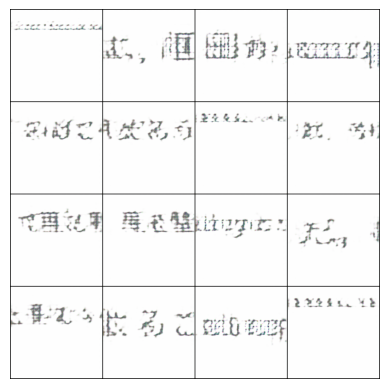

Epoch [30/10000], Step [0/14], Loss_G: 8.104266166687012, Loss_D: 0.43980568647384644
Epoch [31/10000], Step [0/14], Loss_G: 6.496437072753906, Loss_D: 0.6253174543380737
Epoch [32/10000], Step [0/14], Loss_G: 7.710140228271484, Loss_D: 0.3529766798019409
Epoch [33/10000], Step [0/14], Loss_G: 8.130829811096191, Loss_D: 0.41615843772888184
Epoch [34/10000], Step [0/14], Loss_G: 6.847517013549805, Loss_D: 0.4626292586326599
Epoch [35/10000], Step [0/14], Loss_G: 8.403804779052734, Loss_D: 0.5220678448677063
Epoch [36/10000], Step [0/14], Loss_G: 6.683828353881836, Loss_D: 0.38524574041366577
Epoch [37/10000], Step [0/14], Loss_G: 7.0096435546875, Loss_D: 0.45434117317199707
Epoch [38/10000], Step [0/14], Loss_G: 7.512491703033447, Loss_D: 0.3682849407196045
Epoch [39/10000], Step [0/14], Loss_G: 6.602659225463867, Loss_D: 0.34043771028518677


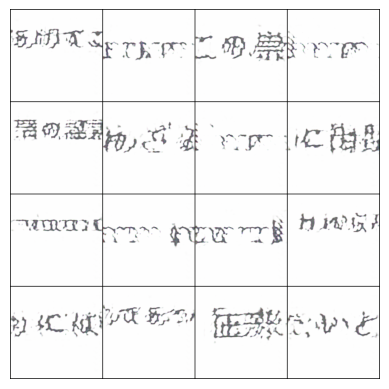

Epoch [40/10000], Step [0/14], Loss_G: 6.763031005859375, Loss_D: 0.4156084656715393
Epoch [41/10000], Step [0/14], Loss_G: 7.39529275894165, Loss_D: 0.45370572805404663
Epoch [42/10000], Step [0/14], Loss_G: 7.177712440490723, Loss_D: 0.45736128091812134
Epoch [43/10000], Step [0/14], Loss_G: 8.284407615661621, Loss_D: 0.532518744468689
Epoch [44/10000], Step [0/14], Loss_G: 7.401732444763184, Loss_D: 0.46264809370040894
Epoch [45/10000], Step [0/14], Loss_G: 5.791098594665527, Loss_D: 0.7919642329216003
Epoch [46/10000], Step [0/14], Loss_G: 7.868913650512695, Loss_D: 0.4432271122932434
Epoch [47/10000], Step [0/14], Loss_G: 6.866682052612305, Loss_D: 0.3465272784233093
Epoch [48/10000], Step [0/14], Loss_G: 6.862286567687988, Loss_D: 0.347148597240448
Epoch [49/10000], Step [0/14], Loss_G: 6.201032638549805, Loss_D: 0.4290452003479004


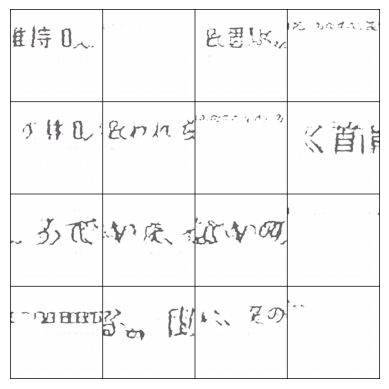

Epoch [50/10000], Step [0/14], Loss_G: 6.243697166442871, Loss_D: 0.5370428562164307
Epoch [51/10000], Step [0/14], Loss_G: 6.697235584259033, Loss_D: 0.5955427885055542
Epoch [52/10000], Step [0/14], Loss_G: 6.137085437774658, Loss_D: 0.44109421968460083
Epoch [53/10000], Step [0/14], Loss_G: 8.900032043457031, Loss_D: 1.0953078269958496
Epoch [54/10000], Step [0/14], Loss_G: 7.538247108459473, Loss_D: 0.5880300402641296
Epoch [55/10000], Step [0/14], Loss_G: 6.388150215148926, Loss_D: 0.3750764727592468
Epoch [56/10000], Step [0/14], Loss_G: 5.65241003036499, Loss_D: 0.6704558730125427
Epoch [57/10000], Step [0/14], Loss_G: 5.922060966491699, Loss_D: 0.4891185462474823
Epoch [58/10000], Step [0/14], Loss_G: 6.485791206359863, Loss_D: 0.4196793735027313
Epoch [59/10000], Step [0/14], Loss_G: 7.118863105773926, Loss_D: 0.38710540533065796


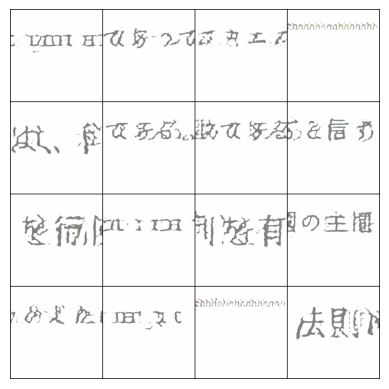

Epoch [60/10000], Step [0/14], Loss_G: 6.423757076263428, Loss_D: 0.37287360429763794
Epoch [61/10000], Step [0/14], Loss_G: 6.083437442779541, Loss_D: 0.4016522169113159
Epoch [62/10000], Step [0/14], Loss_G: 6.5354485511779785, Loss_D: 0.3801029622554779
Epoch [63/10000], Step [0/14], Loss_G: 6.812911033630371, Loss_D: 0.46712198853492737
Epoch [64/10000], Step [0/14], Loss_G: 7.304433345794678, Loss_D: 0.5033714771270752
Epoch [65/10000], Step [0/14], Loss_G: 6.280057430267334, Loss_D: 0.3907589912414551
Epoch [66/10000], Step [0/14], Loss_G: 5.204577922821045, Loss_D: 0.7801134586334229
Epoch [67/10000], Step [0/14], Loss_G: 5.503622055053711, Loss_D: 0.49232596158981323
Epoch [68/10000], Step [0/14], Loss_G: 5.806188583374023, Loss_D: 0.4157736003398895
Epoch [69/10000], Step [0/14], Loss_G: 5.911372661590576, Loss_D: 0.391120582818985


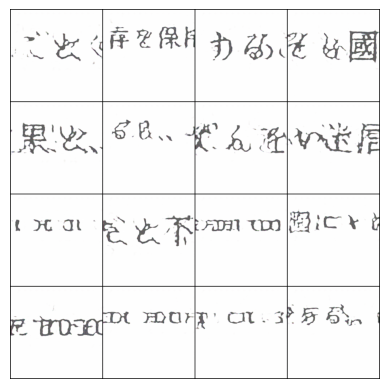

Epoch [70/10000], Step [0/14], Loss_G: 7.4690470695495605, Loss_D: 0.5834097862243652
Epoch [71/10000], Step [0/14], Loss_G: 6.0869646072387695, Loss_D: 0.3901466727256775
Epoch [72/10000], Step [0/14], Loss_G: 5.919912815093994, Loss_D: 0.4145318865776062
Epoch [73/10000], Step [0/14], Loss_G: 5.870713233947754, Loss_D: 0.3884255290031433
Epoch [74/10000], Step [0/14], Loss_G: 5.275686740875244, Loss_D: 0.7058546543121338
Epoch [75/10000], Step [0/14], Loss_G: 5.877272605895996, Loss_D: 0.37708038091659546
Epoch [76/10000], Step [0/14], Loss_G: 7.053030490875244, Loss_D: 0.5796478986740112
Epoch [77/10000], Step [0/14], Loss_G: 4.920565605163574, Loss_D: 0.7548807263374329
Epoch [78/10000], Step [0/14], Loss_G: 5.991814613342285, Loss_D: 0.3498299717903137
Epoch [79/10000], Step [0/14], Loss_G: 5.736011505126953, Loss_D: 0.4560345709323883


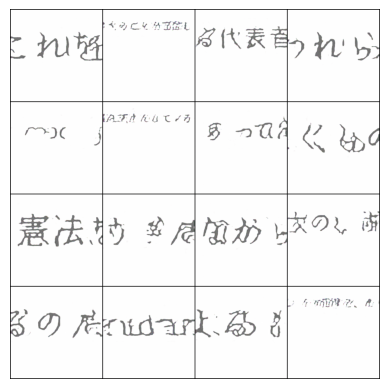

Epoch [80/10000], Step [0/14], Loss_G: 5.259692668914795, Loss_D: 0.43922895193099976
Epoch [81/10000], Step [0/14], Loss_G: 7.032032012939453, Loss_D: 0.5726768970489502
Epoch [82/10000], Step [0/14], Loss_G: 5.397064685821533, Loss_D: 0.5831403136253357
Epoch [83/10000], Step [0/14], Loss_G: 7.003471374511719, Loss_D: 0.46651726961135864
Epoch [84/10000], Step [0/14], Loss_G: 7.045547962188721, Loss_D: 0.6997758150100708
Epoch [85/10000], Step [0/14], Loss_G: 6.930554389953613, Loss_D: 0.651962399482727
Epoch [86/10000], Step [0/14], Loss_G: 5.800011157989502, Loss_D: 0.4197772741317749
Epoch [87/10000], Step [0/14], Loss_G: 6.990481376647949, Loss_D: 0.6511285901069641
Epoch [88/10000], Step [0/14], Loss_G: 5.073767185211182, Loss_D: 0.6425575017929077
Epoch [89/10000], Step [0/14], Loss_G: 5.13846492767334, Loss_D: 0.47563037276268005


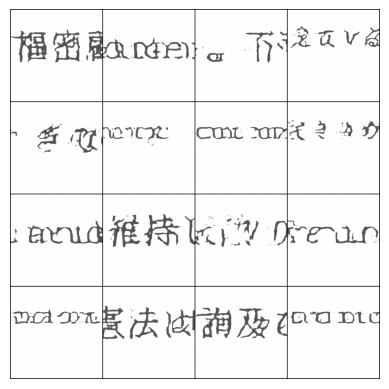

Epoch [90/10000], Step [0/14], Loss_G: 6.755877494812012, Loss_D: 0.4998597502708435
Epoch [91/10000], Step [0/14], Loss_G: 5.14462947845459, Loss_D: 0.4851765036582947
Epoch [92/10000], Step [0/14], Loss_G: 6.580032825469971, Loss_D: 0.4728431701660156
Epoch [93/10000], Step [0/14], Loss_G: 5.473325252532959, Loss_D: 0.408391535282135
Epoch [94/10000], Step [0/14], Loss_G: 6.6888861656188965, Loss_D: 0.6313912868499756
Epoch [95/10000], Step [0/14], Loss_G: 6.2747802734375, Loss_D: 0.3333183526992798
Epoch [96/10000], Step [0/14], Loss_G: 5.669339656829834, Loss_D: 0.36355000734329224
Epoch [97/10000], Step [0/14], Loss_G: 6.177001476287842, Loss_D: 0.4072608947753906
Epoch [98/10000], Step [0/14], Loss_G: 5.22988224029541, Loss_D: 0.5457085967063904
Epoch [99/10000], Step [0/14], Loss_G: 5.534929275512695, Loss_D: 0.39264044165611267


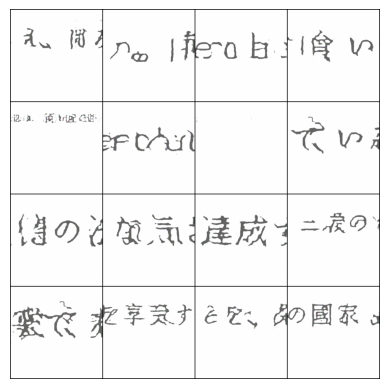

Epoch [100/10000], Step [0/14], Loss_G: 5.633847236633301, Loss_D: 0.36974820494651794
Epoch [101/10000], Step [0/14], Loss_G: 5.991919040679932, Loss_D: 0.4123537242412567
Epoch [102/10000], Step [0/14], Loss_G: 5.098239421844482, Loss_D: 0.46855413913726807
Epoch [103/10000], Step [0/14], Loss_G: 5.728988170623779, Loss_D: 0.39608508348464966
Epoch [104/10000], Step [0/14], Loss_G: 4.890735626220703, Loss_D: 0.42873406410217285
Epoch [105/10000], Step [0/14], Loss_G: 5.077437877655029, Loss_D: 0.43890392780303955
Epoch [106/10000], Step [0/14], Loss_G: 6.415194988250732, Loss_D: 0.4652470648288727
Epoch [107/10000], Step [0/14], Loss_G: 5.93219518661499, Loss_D: 0.4975094795227051
Epoch [108/10000], Step [0/14], Loss_G: 5.150854110717773, Loss_D: 0.4326522946357727
Epoch [109/10000], Step [0/14], Loss_G: 5.386893272399902, Loss_D: 0.38327527046203613


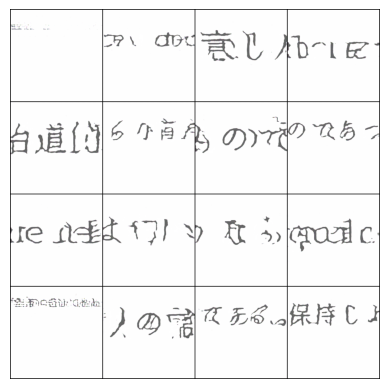

Epoch [110/10000], Step [0/14], Loss_G: 5.295567512512207, Loss_D: 0.47964340448379517
Epoch [111/10000], Step [0/14], Loss_G: 5.085777759552002, Loss_D: 0.47556352615356445
Epoch [112/10000], Step [0/14], Loss_G: 6.038210868835449, Loss_D: 0.4095468819141388
Epoch [113/10000], Step [0/14], Loss_G: 4.950577735900879, Loss_D: 0.45117583870887756
Epoch [114/10000], Step [0/14], Loss_G: 5.841638088226318, Loss_D: 0.43098270893096924
Epoch [115/10000], Step [0/14], Loss_G: 5.932463645935059, Loss_D: 0.4871373772621155
Epoch [116/10000], Step [0/14], Loss_G: 5.292418479919434, Loss_D: 0.42140430212020874
Epoch [117/10000], Step [0/14], Loss_G: 5.099963188171387, Loss_D: 0.37544065713882446
Epoch [118/10000], Step [0/14], Loss_G: 5.327184677124023, Loss_D: 0.3776471018791199
Epoch [119/10000], Step [0/14], Loss_G: 7.34207820892334, Loss_D: 0.26648232340812683


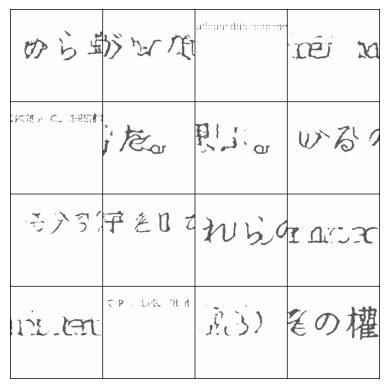

Epoch [120/10000], Step [0/14], Loss_G: 4.654976844787598, Loss_D: 0.7869338989257812
Epoch [121/10000], Step [0/14], Loss_G: 4.924417972564697, Loss_D: 0.4312146306037903
Epoch [122/10000], Step [0/14], Loss_G: 6.243563175201416, Loss_D: 0.4642004370689392
Epoch [123/10000], Step [0/14], Loss_G: 5.364981651306152, Loss_D: 0.3654462993144989
Epoch [124/10000], Step [0/14], Loss_G: 5.045423984527588, Loss_D: 0.5362957715988159
Epoch [125/10000], Step [0/14], Loss_G: 5.714123249053955, Loss_D: 0.47627025842666626
Epoch [126/10000], Step [0/14], Loss_G: 5.001692771911621, Loss_D: 0.396564245223999
Epoch [127/10000], Step [0/14], Loss_G: 4.300166606903076, Loss_D: 0.5598258376121521
Epoch [128/10000], Step [0/14], Loss_G: 5.051469802856445, Loss_D: 0.4308691918849945
Epoch [129/10000], Step [0/14], Loss_G: 5.164788722991943, Loss_D: 0.3917604088783264


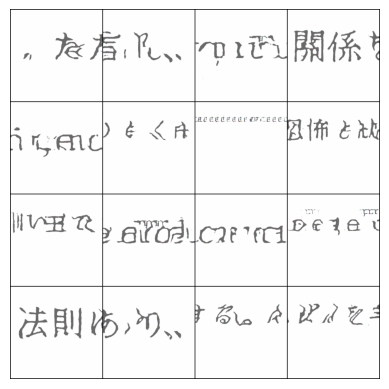

Epoch [130/10000], Step [0/14], Loss_G: 5.763246536254883, Loss_D: 0.40979593992233276
Epoch [131/10000], Step [0/14], Loss_G: 5.442110061645508, Loss_D: 0.4873945415019989
Epoch [132/10000], Step [0/14], Loss_G: 5.011262893676758, Loss_D: 0.3921113610267639
Epoch [133/10000], Step [0/14], Loss_G: 4.625111103057861, Loss_D: 0.6431417465209961
Epoch [134/10000], Step [0/14], Loss_G: 4.571047782897949, Loss_D: 0.4548090100288391
Epoch [135/10000], Step [0/14], Loss_G: 4.7718939781188965, Loss_D: 0.47130468487739563
Epoch [136/10000], Step [0/14], Loss_G: 4.776115894317627, Loss_D: 0.4179605543613434
Epoch [137/10000], Step [0/14], Loss_G: 5.547951698303223, Loss_D: 0.3862253427505493
Epoch [138/10000], Step [0/14], Loss_G: 5.951815605163574, Loss_D: 0.47404271364212036
Epoch [139/10000], Step [0/14], Loss_G: 5.0633625984191895, Loss_D: 0.35247576236724854


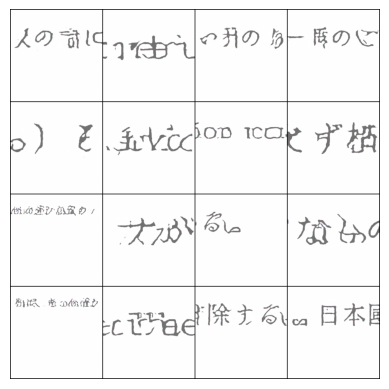

Epoch [140/10000], Step [0/14], Loss_G: 5.669350624084473, Loss_D: 0.4516279101371765
Epoch [141/10000], Step [0/14], Loss_G: 4.730362892150879, Loss_D: 0.5404510498046875
Epoch [142/10000], Step [0/14], Loss_G: 6.309865951538086, Loss_D: 0.6819139122962952
Epoch [143/10000], Step [0/14], Loss_G: 4.28736686706543, Loss_D: 0.48181459307670593
Epoch [144/10000], Step [0/14], Loss_G: 4.6055684089660645, Loss_D: 0.42978760600090027
Epoch [145/10000], Step [0/14], Loss_G: 4.471771240234375, Loss_D: 0.4315530061721802
Epoch [146/10000], Step [0/14], Loss_G: 4.811416149139404, Loss_D: 0.4368699789047241
Epoch [147/10000], Step [0/14], Loss_G: 6.220784664154053, Loss_D: 0.5959780812263489
Epoch [148/10000], Step [0/14], Loss_G: 4.7458600997924805, Loss_D: 0.41458660364151
Epoch [149/10000], Step [0/14], Loss_G: 4.769739627838135, Loss_D: 0.4106728434562683


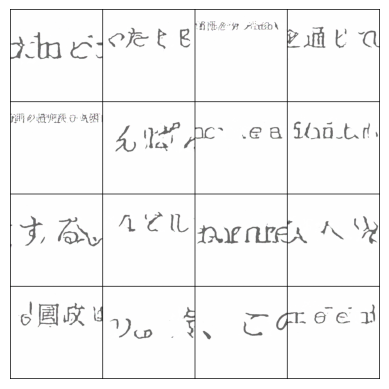

Epoch [150/10000], Step [0/14], Loss_G: 4.580770969390869, Loss_D: 0.5441535711288452
Epoch [151/10000], Step [0/14], Loss_G: 5.59012508392334, Loss_D: 0.592100977897644
Epoch [152/10000], Step [0/14], Loss_G: 5.2949137687683105, Loss_D: 0.4924657344818115
Epoch [153/10000], Step [0/14], Loss_G: 4.782148361206055, Loss_D: 0.3823423683643341
Epoch [154/10000], Step [0/14], Loss_G: 5.419773101806641, Loss_D: 0.3174983263015747
Epoch [155/10000], Step [0/14], Loss_G: 4.3602614402771, Loss_D: 0.565744161605835
Epoch [156/10000], Step [0/14], Loss_G: 5.160271644592285, Loss_D: 0.46146148443222046
Epoch [157/10000], Step [0/14], Loss_G: 4.453581809997559, Loss_D: 0.4516598880290985
Epoch [158/10000], Step [0/14], Loss_G: 5.2733893394470215, Loss_D: 0.423567533493042
Epoch [159/10000], Step [0/14], Loss_G: 4.526155471801758, Loss_D: 0.4320510923862457


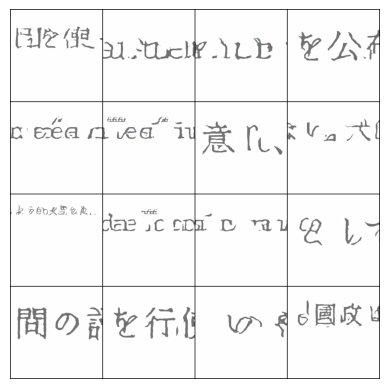

Epoch [160/10000], Step [0/14], Loss_G: 6.328697681427002, Loss_D: 0.5679680109024048
Epoch [161/10000], Step [0/14], Loss_G: 4.705267906188965, Loss_D: 0.4723597466945648
Epoch [162/10000], Step [0/14], Loss_G: 4.8947062492370605, Loss_D: 0.37688231468200684
Epoch [163/10000], Step [0/14], Loss_G: 5.569530010223389, Loss_D: 0.4360211491584778
Epoch [164/10000], Step [0/14], Loss_G: 4.691010475158691, Loss_D: 0.39235353469848633
Epoch [165/10000], Step [0/14], Loss_G: 4.359690189361572, Loss_D: 0.4169871509075165
Epoch [166/10000], Step [0/14], Loss_G: 4.319364547729492, Loss_D: 0.5048629641532898
Epoch [167/10000], Step [0/14], Loss_G: 4.724581718444824, Loss_D: 0.4288524389266968
Epoch [168/10000], Step [0/14], Loss_G: 4.905134677886963, Loss_D: 0.4686548709869385
Epoch [169/10000], Step [0/14], Loss_G: 5.000556468963623, Loss_D: 0.4262775778770447


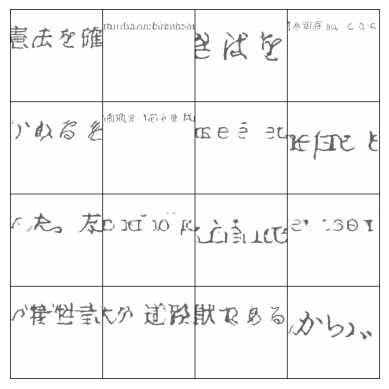

Epoch [170/10000], Step [0/14], Loss_G: 4.783741474151611, Loss_D: 0.4230632781982422
Epoch [171/10000], Step [0/14], Loss_G: 5.264163017272949, Loss_D: 0.46416357159614563
Epoch [172/10000], Step [0/14], Loss_G: 4.579184055328369, Loss_D: 0.40965262055397034
Epoch [173/10000], Step [0/14], Loss_G: 5.901106834411621, Loss_D: 0.4972567558288574
Epoch [174/10000], Step [0/14], Loss_G: 6.341001510620117, Loss_D: 0.6074459552764893
Epoch [175/10000], Step [0/14], Loss_G: 4.360726356506348, Loss_D: 0.5046592354774475
Epoch [176/10000], Step [0/14], Loss_G: 5.058660984039307, Loss_D: 0.3206368386745453
Epoch [177/10000], Step [0/14], Loss_G: 3.8762521743774414, Loss_D: 0.864954948425293
Epoch [178/10000], Step [0/14], Loss_G: 4.9718451499938965, Loss_D: 0.464177668094635
Epoch [179/10000], Step [0/14], Loss_G: 4.327460765838623, Loss_D: 0.43020933866500854


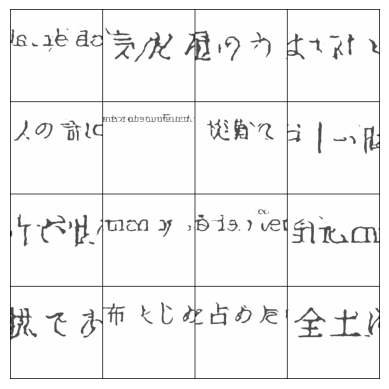

Epoch [180/10000], Step [0/14], Loss_G: 3.8225488662719727, Loss_D: 0.6862902045249939
Epoch [181/10000], Step [0/14], Loss_G: 4.399135589599609, Loss_D: 0.42580050230026245
Epoch [182/10000], Step [0/14], Loss_G: 4.406621932983398, Loss_D: 0.5476540923118591
Epoch [183/10000], Step [0/14], Loss_G: 6.608998775482178, Loss_D: 0.2298625409603119
Epoch [184/10000], Step [0/14], Loss_G: 6.384400367736816, Loss_D: 0.5466299057006836
Epoch [185/10000], Step [0/14], Loss_G: 4.545814514160156, Loss_D: 0.47354060411453247
Epoch [186/10000], Step [0/14], Loss_G: 4.348990440368652, Loss_D: 0.4277116060256958
Epoch [187/10000], Step [0/14], Loss_G: 5.906998634338379, Loss_D: 0.5958567261695862
Epoch [188/10000], Step [0/14], Loss_G: 5.001906394958496, Loss_D: 0.43847689032554626
Epoch [189/10000], Step [0/14], Loss_G: 4.405965805053711, Loss_D: 0.4082472324371338


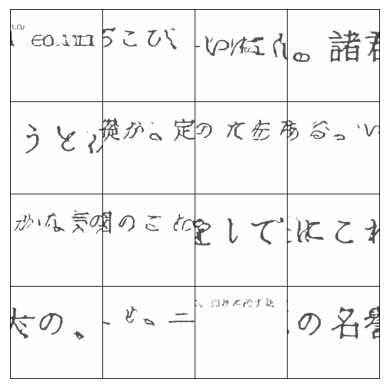

Epoch [190/10000], Step [0/14], Loss_G: 4.570199966430664, Loss_D: 0.7806104421615601
Epoch [191/10000], Step [0/14], Loss_G: 4.168984413146973, Loss_D: 0.5424152612686157
Epoch [192/10000], Step [0/14], Loss_G: 4.010554790496826, Loss_D: 0.5364722609519958
Epoch [193/10000], Step [0/14], Loss_G: 4.553505897521973, Loss_D: 0.38621968030929565
Epoch [194/10000], Step [0/14], Loss_G: 4.940576553344727, Loss_D: 0.403042733669281
Epoch [195/10000], Step [0/14], Loss_G: 5.544139862060547, Loss_D: 0.43032675981521606
Epoch [196/10000], Step [0/14], Loss_G: 4.484677314758301, Loss_D: 0.46695125102996826
Epoch [197/10000], Step [0/14], Loss_G: 4.7937703132629395, Loss_D: 0.39474618434906006
Epoch [198/10000], Step [0/14], Loss_G: 4.633819580078125, Loss_D: 0.40406134724617004
Epoch [199/10000], Step [0/14], Loss_G: 4.718507766723633, Loss_D: 0.37197330594062805


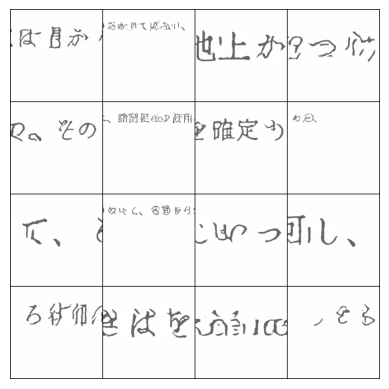

Epoch [200/10000], Step [0/14], Loss_G: 4.650912761688232, Loss_D: 0.36552315950393677
Epoch [201/10000], Step [0/14], Loss_G: 4.822872161865234, Loss_D: 0.4853179156780243
Epoch [202/10000], Step [0/14], Loss_G: 4.796242713928223, Loss_D: 0.48256418108940125
Epoch [203/10000], Step [0/14], Loss_G: 4.649307727813721, Loss_D: 0.3998323082923889
Epoch [204/10000], Step [0/14], Loss_G: 4.006272792816162, Loss_D: 0.45682865381240845
Epoch [205/10000], Step [0/14], Loss_G: 4.643558502197266, Loss_D: 0.8427498936653137
Epoch [206/10000], Step [0/14], Loss_G: 4.184016227722168, Loss_D: 0.48511356115341187
Epoch [207/10000], Step [0/14], Loss_G: 4.261910438537598, Loss_D: 0.4000653922557831
Epoch [208/10000], Step [0/14], Loss_G: 4.199215888977051, Loss_D: 0.4508858323097229
Epoch [209/10000], Step [0/14], Loss_G: 5.049554824829102, Loss_D: 0.3086654543876648


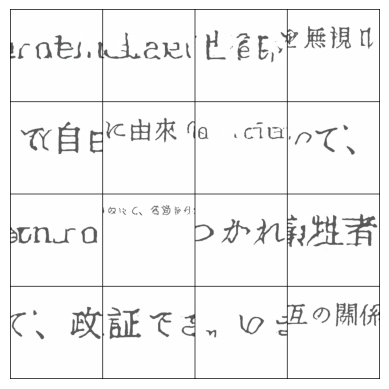

Epoch [210/10000], Step [0/14], Loss_G: 4.504364013671875, Loss_D: 0.35795384645462036
Epoch [211/10000], Step [0/14], Loss_G: 5.347721099853516, Loss_D: 0.4684121906757355
Epoch [212/10000], Step [0/14], Loss_G: 4.966265678405762, Loss_D: 0.43602412939071655
Epoch [213/10000], Step [0/14], Loss_G: 6.5394792556762695, Loss_D: 0.17907771468162537
Epoch [214/10000], Step [0/14], Loss_G: 6.130036354064941, Loss_D: 0.49587273597717285
Epoch [215/10000], Step [0/14], Loss_G: 4.915757656097412, Loss_D: 0.29761725664138794
Epoch [216/10000], Step [0/14], Loss_G: 6.584475040435791, Loss_D: 0.2452879101037979
Epoch [217/10000], Step [0/14], Loss_G: 4.231009483337402, Loss_D: 0.5717983245849609
Epoch [218/10000], Step [0/14], Loss_G: 4.085471153259277, Loss_D: 0.5247249007225037
Epoch [219/10000], Step [0/14], Loss_G: 4.222070693969727, Loss_D: 0.48050180077552795


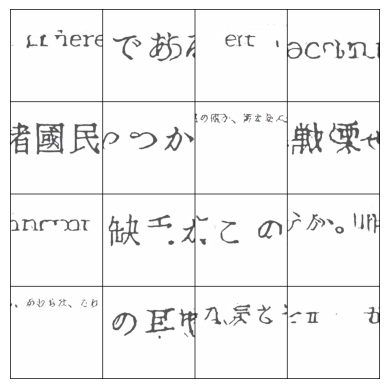

Epoch [220/10000], Step [0/14], Loss_G: 4.56870174407959, Loss_D: 0.45434263348579407
Epoch [221/10000], Step [0/14], Loss_G: 4.567898750305176, Loss_D: 0.43008124828338623
Epoch [222/10000], Step [0/14], Loss_G: 4.72193717956543, Loss_D: 0.3947526216506958
Epoch [223/10000], Step [0/14], Loss_G: 4.534646987915039, Loss_D: 0.3679410517215729
Epoch [224/10000], Step [0/14], Loss_G: 4.190770626068115, Loss_D: 0.5712993144989014
Epoch [225/10000], Step [0/14], Loss_G: 3.8698348999023438, Loss_D: 0.47234103083610535
Epoch [226/10000], Step [0/14], Loss_G: 4.217151641845703, Loss_D: 0.402396559715271
Epoch [227/10000], Step [0/14], Loss_G: 5.066371440887451, Loss_D: 0.37692421674728394
Epoch [228/10000], Step [0/14], Loss_G: 4.353892803192139, Loss_D: 0.38550227880477905
Epoch [229/10000], Step [0/14], Loss_G: 4.666712284088135, Loss_D: 0.3502797484397888


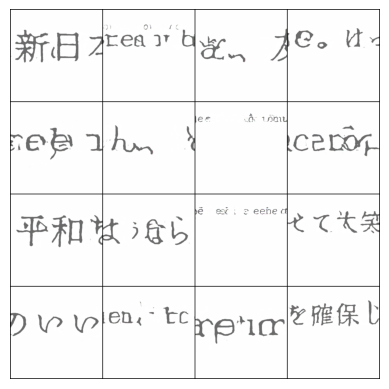

Epoch [230/10000], Step [0/14], Loss_G: 5.053136825561523, Loss_D: 0.35204780101776123
Epoch [231/10000], Step [0/14], Loss_G: 3.8429479598999023, Loss_D: 0.5230758190155029
Epoch [232/10000], Step [0/14], Loss_G: 4.242952346801758, Loss_D: 0.3968605399131775
Epoch [233/10000], Step [0/14], Loss_G: 4.955416679382324, Loss_D: 0.361603319644928
Epoch [234/10000], Step [0/14], Loss_G: 5.473445415496826, Loss_D: 0.3093222379684448
Epoch [235/10000], Step [0/14], Loss_G: 4.471932411193848, Loss_D: 0.30958425998687744
Epoch [236/10000], Step [0/14], Loss_G: 4.232364177703857, Loss_D: 0.5616211891174316
Epoch [237/10000], Step [0/14], Loss_G: 4.96134090423584, Loss_D: 0.49537211656570435
Epoch [238/10000], Step [0/14], Loss_G: 4.49416446685791, Loss_D: 0.3603527545928955
Epoch [239/10000], Step [0/14], Loss_G: 4.507652282714844, Loss_D: 0.33544397354125977


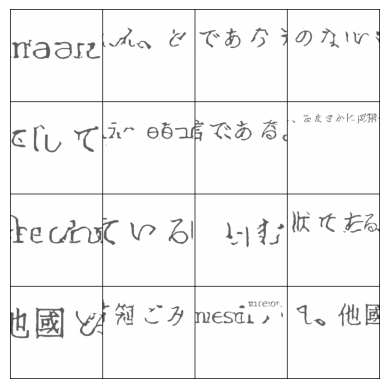

Epoch [240/10000], Step [0/14], Loss_G: 4.273080825805664, Loss_D: 0.40797433257102966
Epoch [241/10000], Step [0/14], Loss_G: 4.8344950675964355, Loss_D: 0.3715429902076721
Epoch [242/10000], Step [0/14], Loss_G: 5.029242992401123, Loss_D: 0.3159586489200592
Epoch [243/10000], Step [0/14], Loss_G: 3.8790810108184814, Loss_D: 0.6216123104095459
Epoch [244/10000], Step [0/14], Loss_G: 4.185888290405273, Loss_D: 0.4141749143600464
Epoch [245/10000], Step [0/14], Loss_G: 5.002844333648682, Loss_D: 0.3775957524776459
Epoch [246/10000], Step [0/14], Loss_G: 4.754798889160156, Loss_D: 0.34799623489379883
Epoch [247/10000], Step [0/14], Loss_G: 3.984180450439453, Loss_D: 0.41901516914367676
Epoch [248/10000], Step [0/14], Loss_G: 4.532153129577637, Loss_D: 0.5027936697006226
Epoch [249/10000], Step [0/14], Loss_G: 4.31697416305542, Loss_D: 0.3282777667045593


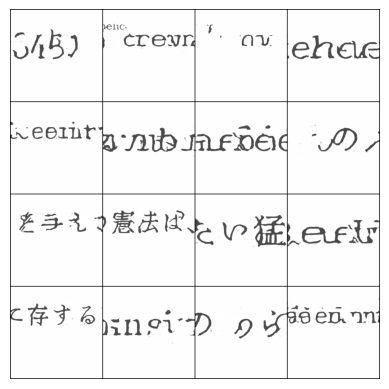

Epoch [250/10000], Step [0/14], Loss_G: 4.5491132736206055, Loss_D: 0.4477340877056122
Epoch [251/10000], Step [0/14], Loss_G: 4.070863723754883, Loss_D: 0.42079001665115356
Epoch [252/10000], Step [0/14], Loss_G: 4.659771919250488, Loss_D: 0.4102364182472229
Epoch [253/10000], Step [0/14], Loss_G: 4.480387210845947, Loss_D: 0.41021281480789185
Epoch [254/10000], Step [0/14], Loss_G: 6.192397594451904, Loss_D: 0.37376660108566284
Epoch [255/10000], Step [0/14], Loss_G: 8.888611793518066, Loss_D: 0.7131425142288208
Epoch [256/10000], Step [0/14], Loss_G: 8.55372428894043, Loss_D: 0.16462233662605286
Epoch [257/10000], Step [0/14], Loss_G: 8.177993774414062, Loss_D: 0.12904909253120422
Epoch [258/10000], Step [0/14], Loss_G: 8.948630332946777, Loss_D: 0.8360050320625305
Epoch [259/10000], Step [0/14], Loss_G: 6.219278335571289, Loss_D: 0.28313249349594116


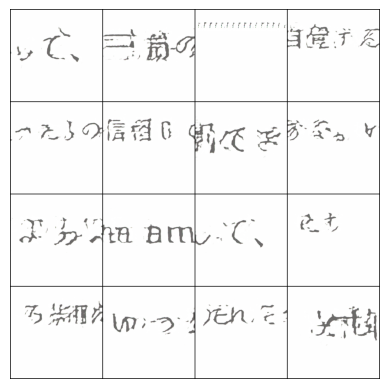

Epoch [260/10000], Step [0/14], Loss_G: 6.204667091369629, Loss_D: 0.22507727146148682
Epoch [261/10000], Step [0/14], Loss_G: 8.110706329345703, Loss_D: 0.19718040525913239
Epoch [262/10000], Step [0/14], Loss_G: 6.869842052459717, Loss_D: 0.1347145140171051
Epoch [263/10000], Step [0/14], Loss_G: 8.456025123596191, Loss_D: 0.3252735137939453
Epoch [264/10000], Step [0/14], Loss_G: 7.21258020401001, Loss_D: 0.0901966542005539
Epoch [265/10000], Step [0/14], Loss_G: 5.982700824737549, Loss_D: 0.4539770781993866
Epoch [266/10000], Step [0/14], Loss_G: 5.973879337310791, Loss_D: 0.22558265924453735
Epoch [267/10000], Step [0/14], Loss_G: 6.320858478546143, Loss_D: 0.13787347078323364
Epoch [268/10000], Step [0/14], Loss_G: 7.632490158081055, Loss_D: 0.3298204839229584
Epoch [269/10000], Step [0/14], Loss_G: 6.038010597229004, Loss_D: 0.22379085421562195


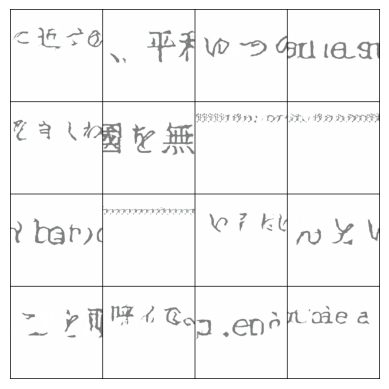

Epoch [270/10000], Step [0/14], Loss_G: 8.166438102722168, Loss_D: 0.16628606617450714
Epoch [271/10000], Step [0/14], Loss_G: 6.87637996673584, Loss_D: 0.19964097440242767
Epoch [272/10000], Step [0/14], Loss_G: 5.914783477783203, Loss_D: 0.16275076568126678
Epoch [273/10000], Step [0/14], Loss_G: 6.3469343185424805, Loss_D: 0.15007391571998596
Epoch [274/10000], Step [0/14], Loss_G: 5.952869415283203, Loss_D: 0.17054584622383118
Epoch [275/10000], Step [0/14], Loss_G: 6.566713809967041, Loss_D: 0.10873731970787048
Epoch [276/10000], Step [0/14], Loss_G: 6.51132345199585, Loss_D: 0.09313571453094482
Epoch [277/10000], Step [0/14], Loss_G: 6.570923328399658, Loss_D: 0.10651577264070511
Epoch [278/10000], Step [0/14], Loss_G: 5.414618492126465, Loss_D: 0.2179662585258484
Epoch [279/10000], Step [0/14], Loss_G: 5.354140758514404, Loss_D: 0.19285358488559723


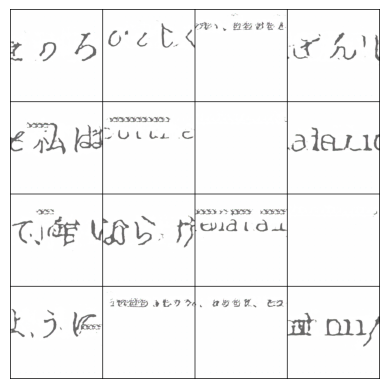

Epoch [280/10000], Step [0/14], Loss_G: 8.414920806884766, Loss_D: 0.7510917782783508
Epoch [281/10000], Step [0/14], Loss_G: 5.052425384521484, Loss_D: 0.33364999294281006
Epoch [282/10000], Step [0/14], Loss_G: 4.593271732330322, Loss_D: 0.56563401222229
Epoch [283/10000], Step [0/14], Loss_G: 5.640788555145264, Loss_D: 0.23921632766723633
Epoch [284/10000], Step [0/14], Loss_G: 5.374958038330078, Loss_D: 0.6049020886421204
Epoch [285/10000], Step [0/14], Loss_G: 6.140364646911621, Loss_D: 0.2159581482410431
Epoch [286/10000], Step [0/14], Loss_G: 7.135673522949219, Loss_D: 0.34952491521835327
Epoch [287/10000], Step [0/14], Loss_G: 6.508119583129883, Loss_D: 0.09571614861488342
Epoch [288/10000], Step [0/14], Loss_G: 5.9050188064575195, Loss_D: 0.1424117535352707
Epoch [289/10000], Step [0/14], Loss_G: 7.187963485717773, Loss_D: 0.09024883806705475


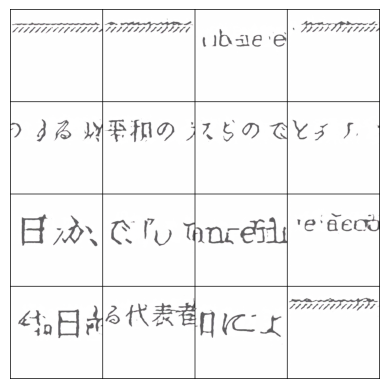

Epoch [290/10000], Step [0/14], Loss_G: 8.023652076721191, Loss_D: 0.05459369346499443
Epoch [291/10000], Step [0/14], Loss_G: 7.490009784698486, Loss_D: 0.053607210516929626
Epoch [292/10000], Step [0/14], Loss_G: 7.802927017211914, Loss_D: 0.0668240487575531
Epoch [293/10000], Step [0/14], Loss_G: 6.05675745010376, Loss_D: 0.13015639781951904
Epoch [294/10000], Step [0/14], Loss_G: 10.287740707397461, Loss_D: 1.0794053077697754
Epoch [295/10000], Step [0/14], Loss_G: 6.833346366882324, Loss_D: 0.39624014496803284
Epoch [296/10000], Step [0/14], Loss_G: 7.174942970275879, Loss_D: 0.08896459639072418
Epoch [297/10000], Step [0/14], Loss_G: 5.211136817932129, Loss_D: 0.21725623309612274
Epoch [298/10000], Step [0/14], Loss_G: 7.167925834655762, Loss_D: 0.10223114490509033
Epoch [299/10000], Step [0/14], Loss_G: 4.622441291809082, Loss_D: 0.9124886393547058


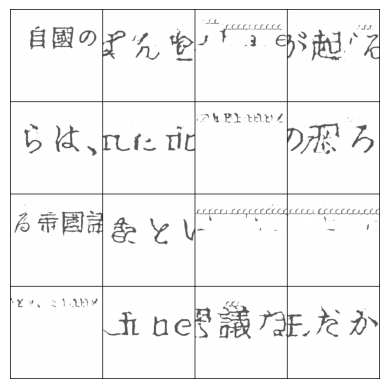

Epoch [300/10000], Step [0/14], Loss_G: 6.013520240783691, Loss_D: 0.20558619499206543
Epoch [301/10000], Step [0/14], Loss_G: 4.955971717834473, Loss_D: 0.2868238687515259
Epoch [302/10000], Step [0/14], Loss_G: 4.93596076965332, Loss_D: 0.31881779432296753
Epoch [303/10000], Step [0/14], Loss_G: 6.021783828735352, Loss_D: 0.20260994136333466
Epoch [304/10000], Step [0/14], Loss_G: 5.833688735961914, Loss_D: 0.1766849309206009
Epoch [305/10000], Step [0/14], Loss_G: 5.39721155166626, Loss_D: 0.2156616747379303
Epoch [306/10000], Step [0/14], Loss_G: 4.7100629806518555, Loss_D: 0.29190078377723694
Epoch [307/10000], Step [0/14], Loss_G: 6.246409893035889, Loss_D: 0.12739597260951996
Epoch [308/10000], Step [0/14], Loss_G: 6.08664608001709, Loss_D: 0.17080242931842804
Epoch [309/10000], Step [0/14], Loss_G: 6.093191623687744, Loss_D: 0.15065236389636993


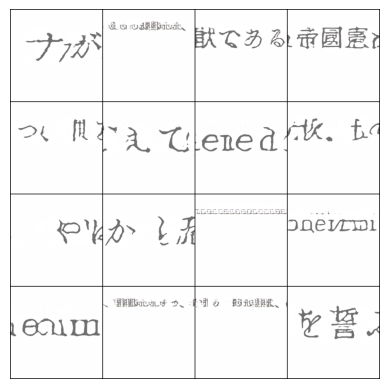

Epoch [310/10000], Step [0/14], Loss_G: 4.2429728507995605, Loss_D: 0.6731718182563782
Epoch [311/10000], Step [0/14], Loss_G: 6.38620662689209, Loss_D: 0.150223970413208
Epoch [312/10000], Step [0/14], Loss_G: 5.608417510986328, Loss_D: 0.18109603226184845
Epoch [313/10000], Step [0/14], Loss_G: 6.020271301269531, Loss_D: 0.34569352865219116
Epoch [314/10000], Step [0/14], Loss_G: 5.574102401733398, Loss_D: 0.2197776436805725
Epoch [315/10000], Step [0/14], Loss_G: 7.032567977905273, Loss_D: 0.5935971736907959
Epoch [316/10000], Step [0/14], Loss_G: 6.648271560668945, Loss_D: 0.1243051290512085
Epoch [317/10000], Step [0/14], Loss_G: 6.820706367492676, Loss_D: 0.07521750777959824
Epoch [318/10000], Step [0/14], Loss_G: 5.801011562347412, Loss_D: 0.19311422109603882
Epoch [319/10000], Step [0/14], Loss_G: 6.054800987243652, Loss_D: 0.1155300885438919


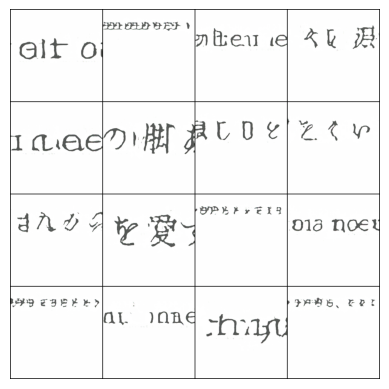

Epoch [320/10000], Step [0/14], Loss_G: 9.44693374633789, Loss_D: 0.5106899738311768
Epoch [321/10000], Step [0/14], Loss_G: 7.081086158752441, Loss_D: 0.15893305838108063
Epoch [322/10000], Step [0/14], Loss_G: 6.454985618591309, Loss_D: 0.08636684715747833
Epoch [323/10000], Step [0/14], Loss_G: 4.816927909851074, Loss_D: 0.3560866713523865
Epoch [324/10000], Step [0/14], Loss_G: 7.129680633544922, Loss_D: 0.0951564759016037
Epoch [325/10000], Step [0/14], Loss_G: 5.973060607910156, Loss_D: 0.1174699142575264
Epoch [326/10000], Step [0/14], Loss_G: 5.056371688842773, Loss_D: 0.2698529362678528
Epoch [327/10000], Step [0/14], Loss_G: 3.9739906787872314, Loss_D: 0.6437548995018005
Epoch [328/10000], Step [0/14], Loss_G: 5.703744888305664, Loss_D: 0.3189845681190491
Epoch [329/10000], Step [0/14], Loss_G: 5.933859825134277, Loss_D: 0.37185001373291016


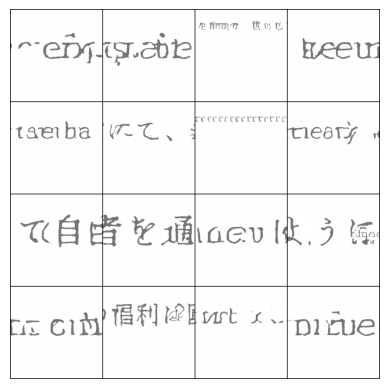

Epoch [330/10000], Step [0/14], Loss_G: 5.403994560241699, Loss_D: 0.205882266163826
Epoch [331/10000], Step [0/14], Loss_G: 6.841800689697266, Loss_D: 0.24657192826271057
Epoch [332/10000], Step [0/14], Loss_G: 4.869977951049805, Loss_D: 0.37493184208869934
Epoch [333/10000], Step [0/14], Loss_G: 5.487461090087891, Loss_D: 0.24305766820907593
Epoch [334/10000], Step [0/14], Loss_G: 4.956085205078125, Loss_D: 0.2546647787094116
Epoch [335/10000], Step [0/14], Loss_G: 7.149667263031006, Loss_D: 0.08581440150737762
Epoch [336/10000], Step [0/14], Loss_G: 6.454214096069336, Loss_D: 0.09885002672672272
Epoch [337/10000], Step [0/14], Loss_G: 6.144923210144043, Loss_D: 0.15681204199790955
Epoch [338/10000], Step [0/14], Loss_G: 7.240628719329834, Loss_D: 0.1786055713891983
Epoch [339/10000], Step [0/14], Loss_G: 5.004157066345215, Loss_D: 0.30284303426742554


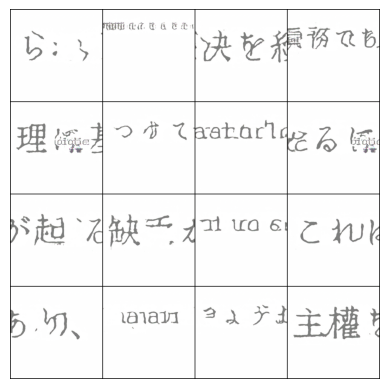

Epoch [340/10000], Step [0/14], Loss_G: 4.452124118804932, Loss_D: 0.5239273309707642
Epoch [341/10000], Step [0/14], Loss_G: 5.53726863861084, Loss_D: 0.19555522501468658
Epoch [342/10000], Step [0/14], Loss_G: 6.666504859924316, Loss_D: 0.13770240545272827
Epoch [343/10000], Step [0/14], Loss_G: 6.262581825256348, Loss_D: 0.1377541869878769
Epoch [344/10000], Step [0/14], Loss_G: 5.70380973815918, Loss_D: 0.1841018795967102
Epoch [345/10000], Step [0/14], Loss_G: 5.918302059173584, Loss_D: 0.11346562206745148
Epoch [346/10000], Step [0/14], Loss_G: 6.4003095626831055, Loss_D: 0.09903690218925476
Epoch [347/10000], Step [0/14], Loss_G: 5.881426811218262, Loss_D: 0.18103277683258057
Epoch [348/10000], Step [0/14], Loss_G: 5.241811275482178, Loss_D: 0.27216413617134094
Epoch [349/10000], Step [0/14], Loss_G: 5.685410499572754, Loss_D: 0.13306301832199097


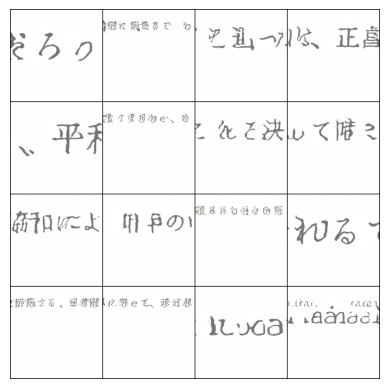

Epoch [350/10000], Step [0/14], Loss_G: 6.107464790344238, Loss_D: 0.1644069254398346
Epoch [351/10000], Step [0/14], Loss_G: 6.030295372009277, Loss_D: 0.10978086292743683
Epoch [352/10000], Step [0/14], Loss_G: 5.070627212524414, Loss_D: 0.28065064549446106
Epoch [353/10000], Step [0/14], Loss_G: 5.653989791870117, Loss_D: 0.18837812542915344
Epoch [354/10000], Step [0/14], Loss_G: 4.956737041473389, Loss_D: 0.29063352942466736
Epoch [355/10000], Step [0/14], Loss_G: 6.087926864624023, Loss_D: 0.1512051224708557
Epoch [356/10000], Step [0/14], Loss_G: 6.175529956817627, Loss_D: 0.08265101164579391
Epoch [357/10000], Step [0/14], Loss_G: 6.177737236022949, Loss_D: 0.5248970985412598
Epoch [358/10000], Step [0/14], Loss_G: 4.8809990882873535, Loss_D: 0.32969412207603455
Epoch [359/10000], Step [0/14], Loss_G: 6.458312034606934, Loss_D: 0.16766521334648132


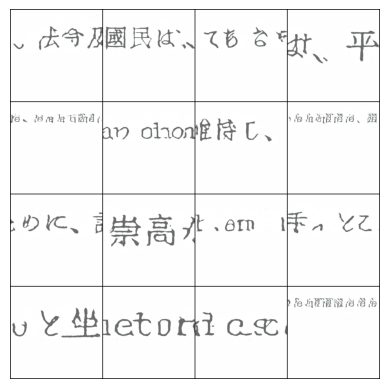

Epoch [360/10000], Step [0/14], Loss_G: 6.05226993560791, Loss_D: 0.2193339765071869
Epoch [361/10000], Step [0/14], Loss_G: 5.201192855834961, Loss_D: 0.2173103392124176
Epoch [362/10000], Step [0/14], Loss_G: 5.985770225524902, Loss_D: 0.16136842966079712
Epoch [363/10000], Step [0/14], Loss_G: 5.300894737243652, Loss_D: 0.16687557101249695
Epoch [364/10000], Step [0/14], Loss_G: 5.546566963195801, Loss_D: 0.24303025007247925
Epoch [365/10000], Step [0/14], Loss_G: 7.597220420837402, Loss_D: 0.06448861211538315
Epoch [366/10000], Step [0/14], Loss_G: 4.88486385345459, Loss_D: 0.26364558935165405
Epoch [367/10000], Step [0/14], Loss_G: 5.6616950035095215, Loss_D: 0.20572660863399506
Epoch [368/10000], Step [0/14], Loss_G: 5.3876495361328125, Loss_D: 0.15583166480064392
Epoch [369/10000], Step [0/14], Loss_G: 6.812700271606445, Loss_D: 0.06682854890823364


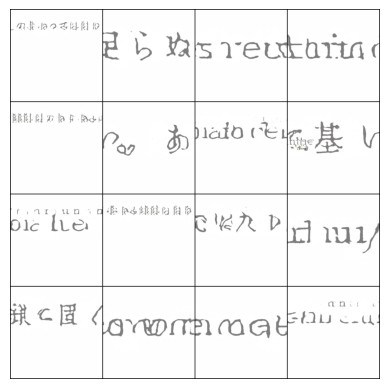

Epoch [370/10000], Step [0/14], Loss_G: 6.397230625152588, Loss_D: 0.18616095185279846
Epoch [371/10000], Step [0/14], Loss_G: 7.914907932281494, Loss_D: 0.27352064847946167
Epoch [372/10000], Step [0/14], Loss_G: 5.776778221130371, Loss_D: 0.19550609588623047
Epoch [373/10000], Step [0/14], Loss_G: 5.850086688995361, Loss_D: 0.12592169642448425
Epoch [374/10000], Step [0/14], Loss_G: 6.331812858581543, Loss_D: 0.08456387370824814
Epoch [375/10000], Step [0/14], Loss_G: 5.758133888244629, Loss_D: 0.12375780940055847
Epoch [376/10000], Step [0/14], Loss_G: 6.431787014007568, Loss_D: 0.10677389800548553
Epoch [377/10000], Step [0/14], Loss_G: 7.883058547973633, Loss_D: 0.12525969743728638
Epoch [378/10000], Step [0/14], Loss_G: 6.893161773681641, Loss_D: 0.059541694819927216
Epoch [379/10000], Step [0/14], Loss_G: 5.904794216156006, Loss_D: 0.1176796555519104


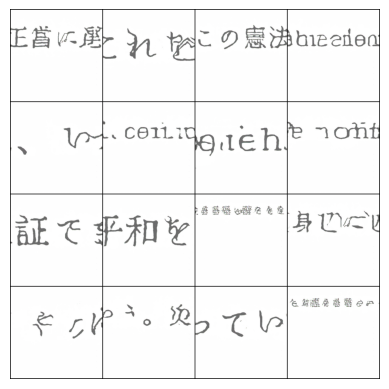

Epoch [380/10000], Step [0/14], Loss_G: 4.758644104003906, Loss_D: 0.26514217257499695
Epoch [381/10000], Step [0/14], Loss_G: 11.060588836669922, Loss_D: 1.12372887134552
Epoch [382/10000], Step [0/14], Loss_G: 8.899768829345703, Loss_D: 0.34748968482017517
Epoch [383/10000], Step [0/14], Loss_G: 9.999550819396973, Loss_D: 0.3415662944316864
Epoch [384/10000], Step [0/14], Loss_G: 8.59439468383789, Loss_D: 0.04259616136550903
Epoch [385/10000], Step [0/14], Loss_G: 7.898334503173828, Loss_D: 0.6147484183311462
Epoch [386/10000], Step [0/14], Loss_G: 4.3893537521362305, Loss_D: 0.41666921973228455
Epoch [387/10000], Step [0/14], Loss_G: 5.429811954498291, Loss_D: 0.18349677324295044
Epoch [388/10000], Step [0/14], Loss_G: 4.300869464874268, Loss_D: 0.42843377590179443
Epoch [389/10000], Step [0/14], Loss_G: 5.342278480529785, Loss_D: 0.13338308036327362


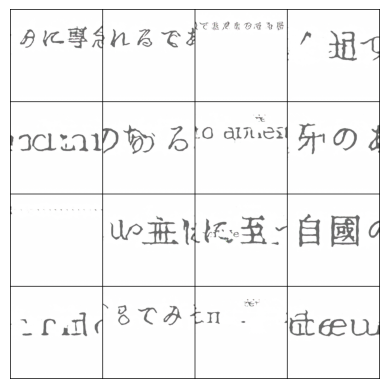

Epoch [390/10000], Step [0/14], Loss_G: 5.929876327514648, Loss_D: 0.10297677665948868
Epoch [391/10000], Step [0/14], Loss_G: 6.465070724487305, Loss_D: 0.1385807991027832
Epoch [392/10000], Step [0/14], Loss_G: 9.62474250793457, Loss_D: 1.3129855394363403
Epoch [393/10000], Step [0/14], Loss_G: 5.092223644256592, Loss_D: 0.47629716992378235
Epoch [394/10000], Step [0/14], Loss_G: 6.521368980407715, Loss_D: 0.19919081032276154
Epoch [395/10000], Step [0/14], Loss_G: 5.523216724395752, Loss_D: 0.2523854374885559
Epoch [396/10000], Step [0/14], Loss_G: 5.332512855529785, Loss_D: 0.24590665102005005
Epoch [397/10000], Step [0/14], Loss_G: 6.080606460571289, Loss_D: 0.10519522428512573
Epoch [398/10000], Step [0/14], Loss_G: 4.260056972503662, Loss_D: 0.507188618183136
Epoch [399/10000], Step [0/14], Loss_G: 5.400339126586914, Loss_D: 0.12196126580238342


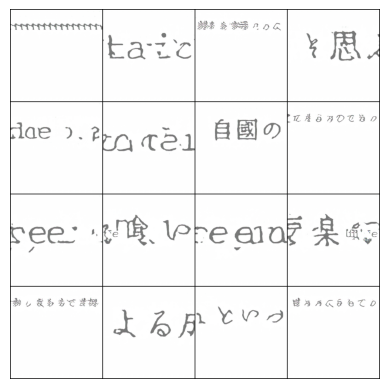

Epoch [400/10000], Step [0/14], Loss_G: 6.361881256103516, Loss_D: 0.11022225022315979
Epoch [401/10000], Step [0/14], Loss_G: 6.3919196128845215, Loss_D: 0.06321331858634949
Epoch [402/10000], Step [0/14], Loss_G: 5.953329086303711, Loss_D: 0.188010573387146
Epoch [403/10000], Step [0/14], Loss_G: 5.18980598449707, Loss_D: 0.17510923743247986
Epoch [404/10000], Step [0/14], Loss_G: 7.476661682128906, Loss_D: 0.08367373794317245
Epoch [405/10000], Step [0/14], Loss_G: 5.000492572784424, Loss_D: 0.2096518576145172
Epoch [406/10000], Step [0/14], Loss_G: 5.802899360656738, Loss_D: 0.08798813819885254
Epoch [407/10000], Step [0/14], Loss_G: 5.802298069000244, Loss_D: 0.32083767652511597


KeyboardInterrupt: 

In [4]:
# 学習する

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
import torchvision

project_dir = "./"

# データセットのパス（Google Drive内のパスに変更）
input_dir = project_dir+'font_data/train/input/'
target_dir = project_dir+'font_data/train/target/'
epoch_dir = project_dir+'output/log/epoch/'
model_dir = project_dir+'output/'

# Generator (U-Net)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Middle
        self.middle = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        return self.decoder(x2)


# Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(6, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=1)
        )

    def forward(self, x):
        return self.model(x)


# Custom Dataset for loading images
class FontDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted(os.listdir(input_dir))
        self.target_images = sorted(os.listdir(target_dir))

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image = os.path.join(self.input_dir, self.input_images[idx])
        target_image = os.path.join(self.target_dir, self.target_images[idx])

        # 画像をPIL Imageとして開く
        input_image = Image.open(input_image)
        target_image = Image.open(target_image)

        # すでにTensorならToTensor()は必要ない
        if self.transform:
            input_image = self.transform(input_image)  # Apply transformation here
            target_image = self.transform(target_image)  # Apply transformation here

        return input_image, target_image

def show_image(tensor_image, max_images=16):
    """
    tensor_image : バッチサイズを持つ Tensor (B, C, H, W)
    max_images   : 表示する画像の最大数
    """
    # サブセットを選択
    if tensor_image.size(0) > max_images:
        tensor_image = tensor_image[:max_images]  # 最初の max_images 枚を取得
    # Tensor を CPU に移動し、[0, 1] の範囲に正規化
    tensor_image = tensor_image.detach().cpu()
    tensor_image = (tensor_image + 1) / 2  # Normalize to [0, 1]
    # グリッド画像を作成
    grid = torchvision.utils.make_grid(tensor_image, nrow=4, padding=2, normalize=True)
    # 画像を表示
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.show()

def main():
    # Hyperparameters
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    batch_size = 256
    num_epochs = 1000
    os.makedirs(os.path.join(epoch_dir), exist_ok=True)

    # Transforms for resizing and normalizing images
    transform = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()])

    # DataLoader setup
    train_dataset = FontDataset(input_dir, target_dir, transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=16)

    # Model, loss functions, and optimizers setup
    generator = Generator().cuda()
    discriminator = Discriminator().cuda()
    # generator = Generator()
    # discriminator = Discriminator()
    criterion_GAN = nn.BCEWithLogitsLoss()
    criterion_L1 = nn.L1Loss()
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    # Training loop
    for epoch in range(num_epochs):
        for i, (input_image, target_image) in enumerate(train_loader):
            input_image, target_image = input_image.cuda(), target_image.cuda()

            # Generator training
            optimizer_G.zero_grad()
            gen_output = generator(input_image)

            # Discriminator loss
            pred_fake = discriminator(torch.cat((input_image, gen_output), 1))
            loss_GAN = criterion_GAN(pred_fake, torch.ones_like(pred_fake))
            loss_L1 = criterion_L1(gen_output, target_image) * 100
            loss_G = loss_GAN + loss_L1
            loss_G.backward()
            optimizer_G.step()

            # Discriminator training
            optimizer_D.zero_grad()
            pred_real = discriminator(torch.cat((input_image, target_image), 1))
            loss_D_real = criterion_GAN(pred_real, torch.ones_like(pred_real))
            pred_fake = discriminator(torch.cat((input_image, gen_output.detach()), 1))
            loss_D_fake = criterion_GAN(pred_fake, torch.zeros_like(pred_fake))
            loss_D = (loss_D_real + loss_D_fake) * 0.5
            loss_D.backward()
            optimizer_D.step()

            # Print logs every 100 steps
            if i % 100 == 0:
                print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss_G: {loss_G.item()}, Loss_D: {loss_D.item()}")

        # Save generated image every 10 epochs
        if (epoch + 1) % 10 == 0:
            show_image(gen_output)
        if (epoch + 1) % 100 == 0:
            torch.save(generator.state_dict(), model_dir+'/generator.'+str(epoch)+'.pth')

    # Save the models after training
    torch.save(generator.state_dict(), model_dir+'/generator.pth')
    torch.save(discriminator.state_dict(), model_dir+'/discriminator.pth')

if __name__ == '__main__':
    main()


In [1]:
print("Hello world")

Hello world
